In [17]:
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.decomposition import PCA
from pprint import pprint

import matplotlib.pyplot as plt
%matplotlib inline

You can get the dataset from https://densitydesign.github.io/strumentalia-seealsology/

__Steps to download:__

a) Enter the following links:

https://en.wikipedia.org/wiki/Space_research

https://en.wikipedia.org/wiki/Space_Race

https://en.wikipedia.org/wiki/Space_exploration

b) Download the TSV file.

In [2]:
df = pd.read_csv("space_data.tsv", sep = "\t")

In [3]:
df.head()

,source,target,depth
0,space exploration,discovery and exploration of the solar system,1
1,space exploration,in-space propulsion technologies,1
2,space exploration,robotic spacecraft,1
3,space exploration,timeline of planetary exploration,1
4,space exploration,landings on other planets,1


In [6]:
df.shape

(3328, 3)

In [4]:
# construct an undirected graph
G=nx.from_pandas_edgelist(df, "source", "target", edge_attr=True, create_using=nx.Graph())

In [5]:
len(G) # number of nodes

2088

In [7]:
G.__class__

networkx.classes.graph.Graph

In [10]:
# function to generate random walk sequences of nodes
def get_randomwalk(node, path_length):
    
    random_walk = [node]
    
    for i in range(path_length-1):
        temp = list(G.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break

        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk

In [11]:
get_randomwalk('space exploration', 10)

['space exploration',
 'interplanetary contamination',
 'space probe',
 'space age',
 'googie architecture',
 'fantastic architecture']

In [12]:
all_nodes = list(G.nodes())

random_walks = []

for n in tqdm(all_nodes):
    for i in range(5):
        random_walks.append(get_randomwalk(n,10))

100%|████████████████████████████████████| 2088/2088 [00:00<00:00, 8700.00it/s]


In [18]:
# count of sequences
pprint(random_walks.__class__)
pprint(random_walks[0:5])

<class 'list'>
[['space exploration',
  'exploration of mars',
  'exomars',
  'mars global remote sensing orbiter and small rover'],
 ['space exploration',
  'venera program',
  'vega program',
  'pioneer venus orbiter',
  'pioneer venus multiprobe'],
 ['space exploration',
  'space research',
  'space science',
  'centennial challenges',
  'antarctica'],
 ['space exploration',
  'mars to stay',
  'inspiration mars foundation',
  'mars direct',
  'mars one',
  'private spaceflight',
  'inspiration mars',
  'effect of spaceflight on the human body',
  'mars analog habitat',
  'present day mars habitability analogue environments on earth'],
 ['space exploration',
  'religion in space',
  'astronomy and religion',
  'astronomy and christianity']]


一个图网络，生成多个序列特征。

In [19]:
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

In [20]:
# train word2vec model
model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(random_walks, progress_per=2)

In [21]:
model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)

(968002, 995020)

In [22]:
print(model)

Word2Vec(vocab=2088, size=100, alpha=0.03)


In [23]:
# find top n similar nodes
model.similar_by_word('astronaut training')

[('micro-g environment', 0.9768314957618713),
 ('reduced-gravity aircraft', 0.9589313268661499),
 ('spaceflight osteopenia', 0.873708963394165),
 ('renal stone formation in space', 0.8724939823150635),
 ('microgravity university', 0.8606730699539185),
 ('space psychology', 0.8559364676475525),
 ('psychological and sociological effects of spaceflight', 0.8460075259208679),
 ('gravitational shielding', 0.844504714012146),
 ('timeline of longest spaceflights', 0.841846764087677),
 ('space adaptation syndrome', 0.8339583873748779)]

In [24]:
terms = ['lunar escape systems','soviet moonshot', 'soyuz 7k-l1', 'moon landing',
         'space food', 'food systems on space exploration missions', 'meal, ready-to-eat',
         'space law', 'metalaw', 'moon treaty', 'legal aspects of computing',
         'astronaut training', 'reduced-gravity aircraft', 'space adaptation syndrome', 'micro-g environment']

In [25]:
def plot_nodes(word_list):
    X = model[word_list]
    
    # reduce dimensions to 2
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    
    
    plt.figure(figsize=(12,9))
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
        
    plt.show()

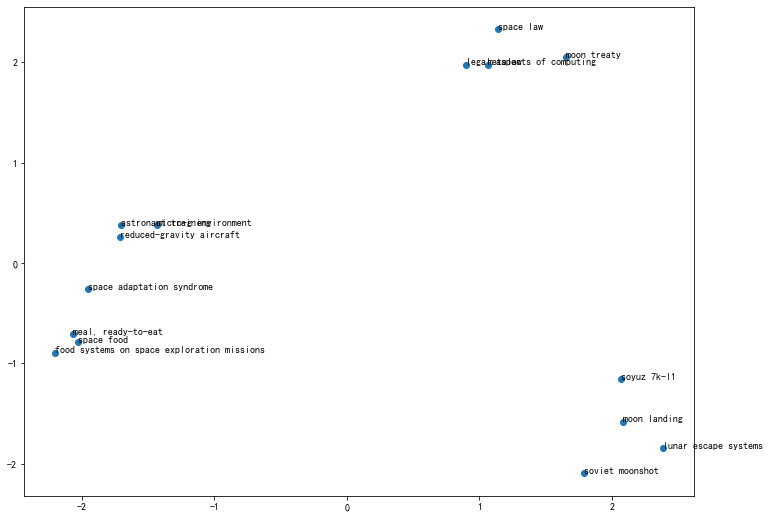

In [26]:
plot_nodes(terms)